# New Section

In [ ]:
#Do not run
#Format of input?
#2D input array into keras
!pip install --target=$nb_path moabb
!pip3 install --target=$nb_path torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
!pip install --target=$nb_path braindecode
#!pip install --target=$nb_path mne
!pip install --target=$nb_path -U https://api.github.com/repos/braindecode/braindecode/zipball/master

In [2]:

import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)


#4/1AX4XfWhv3cBxSin7WYEfMUa4vnyi5O4Cx-MYYR-hW-PeCAYZQBj7CH1b248

Mounted at /content/drive


In [3]:
import io
from google.colab import files
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json


def integers(a, b):
         return list(range(a, b+1))

#config
OutputType = "Envir"
ReadyInput = "/content/drive/My Drive/raw_braindecode_envi"
min_delta = 60*2
delta_threshold = min_delta
n_times_input = 256*60*1
rawlist = integers(1,12)
mainpath = "/content/drive/My Drive/RawEEG_M5/"
#end config


sys.path.insert(0,nb_path)

import cv2
import scipy.signal 
from PIL import Image
from numpy import asarray
import matplotlib
import pathlib
import mne
from braindecode.datautil import create_from_X_y
from braindecode.datautil import save_concat_dataset 
from braindecode.datautil import load_concat_dataset 
from braindecode.datasets import BaseConcatDataset
from braindecode.datasets import BaseDataset
import random
from mne.preprocessing import ICA

/content/notebooks/braindecode/datautil/__init__.py:15: UserWarning: create_from_X_y has been moved to datasets, please use from braindecode.datasets import create_from_X_y
  warn('create_from_X_y has been moved to datasets, please use from braindecode.datasets import create_from_X_y')


In [4]:
filexist = False
#savefile = BaseConcatDataset([])
#savefile = load_concat_dataset(ReadyInput,preload=True)
#filexist = True
!rm -rf "/content/drive/My Drive/raw_braindecode_envi"
!mkdir "/content/drive/My Drive/raw_braindecode_envi"

for i in rawlist: 
  order = str(i)+"/"
  subpath = os.path.join(mainpath,order)

  ################################################
  output_fname = OutputType+".xlsx"
  data_file = os.path.join(subpath, output_fname )
  dump = pd.ExcelFile(data_file)
  HeartRate = dump.parse(OutputType)

  #OutputData = pd.DataFrame(HeartRate[OutputType])
  if (HeartRate["TimeStamp"].size < 1):
    continue
  #################################################
  obci_fname = 'raw.txt'
  data_file = os.path.join(subpath, obci_fname )

  channel_names = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1','O2']
  channel_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg','eeg']
  sfreq = 250  # in Hertz
  montage = 'standard_1020'

  info = mne.create_info(channel_names, sfreq, channel_types)

  n_channels = 8
  sampling_rate = 250
  #info = mne.create_info(n_channels, sampling_rate)
  print(info)




  counter = 0
  window_ = 5
  jumpstep_ = 3
  InputData = []
  OutputData = {}
  queue = {}
  sum_ = {}
  data_arr = np.empty((0, 8))
  time = 0
  timein = 0
  eeg_id = ["1","2","3","4","5","6","7","8"]
  dummy = np.empty((1, 8))
  id = np.zeros((340,1))
  inlen = 0

  sphere_not_define = True
  def createList(n):
      lst = []
      for i in range(n+1):
          lst.append(i)
      return(lst)
  newraw = np.empty((9, 10000000))
  newraw_l = 0
  with open( data_file, 'r' ) as in_f:
      header = True
      while header:
          line = next( in_f )
          if line[0] != '%':
              header = False
      dump = True
      for line in in_f:
          temp = np.array(line.strip( ' \n' ).split( ', ' )[1:23]).astype(np.float)
          newraw[0][newraw_l] = temp[0]
          newraw[1][newraw_l]  = temp[1]
          newraw[2][newraw_l]  = temp[2]
          newraw[3][newraw_l]  = temp[3]
          newraw[4][newraw_l]  = temp[4]
          newraw[5][newraw_l]  = temp[5]
          newraw[6][newraw_l]  = temp[6]
          newraw[7][newraw_l]  = temp[7]
          newraw[8][newraw_l]  = temp[21]
          newraw_l += 1

      newraw = mne.filter.filter_data(newraw[:,0:newraw_l], sfreq, 0.5, 70, picks=createList(7))
      newraw = mne.filter.notch_filter(newraw, sfreq, 50, picks=createList(7))
              
      time_arr = newraw[8]
      
      custom_raw = mne.io.RawArray(newraw[0:8,0:newraw_l], info)
      custom_raw.set_montage('standard_1020')

      #ica = ICA(n_components=8, max_iter='auto', random_state=123)
      #ica.fit(custom_raw)
      #ica.apply(custom_raw)

      if (sphere_not_define):
                sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)
                src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15.)
                forward = mne.make_forward_solution(custom_raw.info, trans=None, src=src, bem=sphere)
                sphere_not_define = False

      custom_raw.set_eeg_reference(ref_channels='REST',forward=forward)

      newraw = np.vstack((custom_raw._data,time_arr[np.newaxis,:]))

      del custom_raw

      for temp in range(newraw_l):
          #np.vstack((data_arr,np.array( line.strip( ' \n' ).split( ', ' )[1:9] )))
          #np.insert(X, 0, 6., axis=0)
          if (dump):
              dump = False
          else:
              #temp = np.array(line.strip( ' \n' ).split( ', ' )[1:23]).astype( np.float )
              time = newraw[8][temp] 
          if (time < HeartRate["TimeStamp"][timein]):
              continue
          if (time > (HeartRate["TimeStamp"][timein]+delta_threshold)):
              counter = 0
              timein += 1      
              data_arr = np.empty((0, 8))
              continue
          counter = counter + 1
          for x in range(8):
            dummy[:,x] = newraw[x][temp]
          data_arr = np.vstack((data_arr,dummy))
            
          if (counter == n_times_input):
              data_arr = data_arr.T
              
              Heartrate = np.array(HeartRate)
              print(Heartrate.shape)
              target = Heartrate[timein,1:12]
              target = np.array(target)

              datasets = []
              #save_concat_dataset("/content/drive/My Drive/raw_braindecode", windows_dataset)
              custom_raw = mne.io.RawArray(data_arr, info)

              #custom_raw.filter(0.5, 70)
              #custom_raw.notch_filter(60)
              custom_raw.set_montage('standard_1020')
              
              data_arr = np.empty((0, 8))

              status = random.randint(1, 10)
              
              target = np.array(target)
              print(target)
              if (status < 9 ):
                f_descrition = pd.Series(
                  data=[target[0],target[1],target[2],target[3],target[4],target[5],target[6],target[7],target[8],target[9],target[10], "train"],
                  index=["target1", "target2", "target3", "target4", "target5", "target6", "target7", "target8", "target9", "target10", "target11","session"])
              else:
                f_descrition = pd.Series(
                  data=[target[0],target[1],target[2],target[3],target[4],target[5],target[6],target[7],target[8],target[9],target[10], "test"],
                  index=["target1", "target2", "target3", "target4", "target5", "target6", "target7", "target8", "target9", "target10", "target11","session"])
              base_ds = BaseDataset(custom_raw, f_descrition, target_name="target1")
              datasets.append(base_ds)
              InputData = BaseConcatDataset(datasets)
              if (filexist):
                savefile = BaseConcatDataset([savefile,InputData])
              else: 
                savefile = BaseConcatDataset(datasets) 
                filexist = True
              print(timein)
              timein += 1
              if (timein >= HeartRate["TimeStamp"].size):
                break
              data_arr = np.empty((0, 8))
              counter = 0
              print(custom_raw.n_times)
save_concat_dataset(ReadyInput, savefile)

#apply Z score later in preprocessing before training



<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, C3, C4, T5, T6, O1, O2
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>
Setting up band-pass filter from 0.5 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 1651 samples (6.604 sec)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stop

<ipython-input-4-bbe3b31d0191>:96: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Equiv. model fitting -> RV = 0.0034856 %
mu1 = 0.944754    lambda1 = 0.137089
mu2 = 0.667504    lambda2 = 0.683819
mu3 = -0.26966    lambda3 = -0.0105378
Set up EEG sphere model with scalp radius    96.4 mm

Sphere                : origin at (0.3 9.5 35.1) mm
              radius  : 86.7 mm
grid                  : 15.0 mm
mindist               : 5.0 mm
Exclude               : 30.0 mm

Setting up the sphere...
Surface CM = (   0.3    9.5   35.1) mm
Surface fits inside a sphere with radius   86.7 mm
Surface extent:
    x =  -86.4 ...   87.0 mm
    y =  -77.2 ...   96.2 mm
    z =  -51.6 ...  121.8 mm
Grid extent:
    x =  -90.0 ...   90.0 mm
    y =  -90.0 ...  105.0 mm
    z =  -60.0 ...  135.0 mm
2548 sources before omitting any.
781 sources after omitting infeasible sources not within 30.0 - 86.7 mm.
644 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.
Source space : MRI voxel -> MRI (surface RAS)
     

<ipython-input-4-bbe3b31d0191>:96: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    8 out of 8 channels remain after picking
(27, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.590e+02 2.550e+02 1.000e-02 2.885e+01 7.700e+01 4.800e+02
 4.930e+02 2.300e+01 2.800e+01 6.700e+00]
2
15360
(27, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.600e+02 2.570e+02 2.000e-02 2.891e+01 7.700e+01 4.820e+02
 5.240e+02 2.000e+01 2.800e+01 6.700e+00]
3
15360
(27, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[6.000e+00 2.610e+02 2.570e+02 2.000e-02 2.882e+01 7.800e+01 4.820e+02
 5.310e+02 2.300e+01 2.800e+01 6.700e+00]
4
15360
(27, 12)
Creating RawArray with float64 data, n_channels=8, n_

<ipython-input-4-bbe3b31d0191>:96: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    8 out of 8 channels remain after picking
(18, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.610e+02 2.560e+02 2.000e-02 2.782e+01 8.000e+01 8.660e+02
 4.080e+02 2.300e+01 4.700e+01 8.300e+00]
2
15360
(18, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.610e+02 2.560e+02 2.000e-02 2.781e+01 8.000e+01 8.650e+02
 4.080e+02 2.600e+01 4.700e+01 8.300e+00]
3
15360
(18, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.610e+02 2.550e+02 2.000e-02 2.768e+01 8.000e+01 8.600e+02
 4.120e+02 3.300e+01 4.700e+01 8.300e+00]
4
15360
(18, 12)
Creating RawArray with float64 data, n_channels=8, n_

<ipython-input-4-bbe3b31d0191>:96: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    8 out of 8 channels remain after picking
(30, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[6.00000e+00 2.61000e+02 2.55000e+02 2.00000e-02 2.98100e+01 7.20000e+01
 8.50000e+02 4.59000e+02 1.70000e+01 3.35000e+02 8.39999e+00]
3
15360
(30, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[5.00000e+00 2.61000e+02 2.57000e+02 2.00000e-02 2.97500e+01 7.20000e+01
 8.49000e+02 4.62000e+02 1.60000e+01 3.42000e+02 8.89999e+00]
4
15360
(30, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[5.00000e+00 2.61000e+02 2.56000e+02 2.00000e-02 2.95900e+01 7.30000e+01
 8.52000e+02 4.62000e+02 1.70000e+01 3.42000e+02 8.89999e+00]
5
15

<ipython-input-4-bbe3b31d0191>:96: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    8 out of 8 channels remain after picking
(35, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.620e+02 2.610e+02 3.000e-02 2.948e+01 7.700e+01 7.190e+02
 4.680e+02 2.900e+01 4.700e+01 6.200e+00]
3
15360
(35, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.00e+00 2.63e+02 2.60e+02 3.00e-02 2.95e+01 7.60e+01 7.20e+02 4.68e+02
 2.90e+01 4.20e+01 6.80e+00]
4
15360
(35, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.610e+02 2.610e+02 2.000e-02 2.959e+01 7.600e+01 7.230e+02
 4.350e+02 2.600e+01 4.200e+01 6.800e+00]
5
15360
(35, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360

<ipython-input-4-bbe3b31d0191>:96: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    8 out of 8 channels remain after picking
(21, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.00e+00 2.60e+02 2.54e+02 2.00e-02 2.81e+01 7.70e+01 5.91e+02 4.04e+02
 4.10e+01 5.40e+01 8.00e+00]
2
15360
(21, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.00e+00 2.62e+02 2.56e+02 3.00e-02 2.80e+01 7.60e+01 6.21e+02 4.10e+02
 3.40e+01 5.40e+01 8.00e+00]
10
15360
(21, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.600e+02 2.560e+02 2.000e-02 2.792e+01 7.600e+01 6.280e+02
 3.980e+02 3.500e+01 5.400e+01 8.000e+00]
11
15360
(21, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Rang

<ipython-input-4-bbe3b31d0191>:96: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    8 out of 8 channels remain after picking
(55, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[2.000e+00 2.610e+02 2.540e+02 2.000e-02 2.904e+01 6.100e+01 1.191e+03
 5.390e+02 4.420e+02 5.400e+01 1.400e+01]
31
15360
(55, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[2.000e+00 2.620e+02 2.560e+02 3.000e-02 2.913e+01 6.100e+01 1.193e+03
 5.240e+02 4.420e+02 5.400e+01 1.400e+01]
32
15360
(55, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[2.000e+00 2.600e+02 2.560e+02 2.000e-02 2.919e+01 6.100e+01 1.193e+03
 5.040e+02 4.420e+02 5.400e+01 1.400e+01]
33
15360
(55, 12)
Creating RawArray with float64 data, n_channels=8,

<ipython-input-4-bbe3b31d0191>:96: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    8 out of 8 channels remain after picking
(23, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.610e+02 2.570e+02 2.000e-02 2.840e+01 7.500e+01 1.141e+03
 5.020e+02 1.100e+01 2.300e+01 7.000e+00]
2
15360
(23, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.600e+02 2.560e+02 2.000e-02 2.837e+01 7.500e+01 1.144e+03
 4.960e+02 1.200e+01 2.700e+01 5.400e+00]
3
15360
(23, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.610e+02 2.570e+02 2.000e-02 2.834e+01 7.500e+01 1.142e+03
 4.880e+02 1.200e+01 2.700e+01 5.400e+00]
4
15360
(23, 12)
Creating RawArray with float64 data, n_channels=8, n_

<ipython-input-4-bbe3b31d0191>:96: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    8 out of 8 channels remain after picking
(46, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.610e+02 2.550e+02 2.000e-02 2.873e+01 7.700e+01 9.090e+02
 4.630e+02 2.000e+01 4.100e+01 1.020e+01]
2
15360
(46, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.610e+02 2.550e+02 2.000e-02 2.862e+01 7.800e+01 9.150e+02
 4.650e+02 1.800e+01 4.100e+01 1.020e+01]
3
15360
(46, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.610e+02 2.550e+02 2.000e-02 2.857e+01 7.700e+01 9.200e+02
 4.620e+02 2.000e+01 4.100e+01 1.020e+01]
4
15360
(46, 12)
Creating RawArray with float64 data, n_channels=8, n_

<ipython-input-4-bbe3b31d0191>:96: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    8 out of 8 channels remain after picking
(35, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.610e+02 2.560e+02 2.000e-02 2.859e+01 7.500e+01 9.640e+02
 4.920e+02 2.000e+01 4.100e+01 1.010e+01]
1
15360
(35, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.600e+02 2.570e+02 2.000e-02 2.847e+01 7.500e+01 9.650e+02
 4.810e+02 1.900e+01 4.100e+01 1.010e+01]
2
15360
(35, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.610e+02 2.570e+02 2.000e-02 2.831e+01 7.500e+01 9.630e+02
 4.720e+02 2.000e+01 4.100e+01 1.010e+01]
3
15360
(35, 12)
Creating RawArray with float64 data, n_channels=8, n_

<ipython-input-4-bbe3b31d0191>:96: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    8 out of 8 channels remain after picking
(25, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.00000e+00 2.60000e+02 2.58000e+02 2.00000e-02 2.83800e+01 7.30000e+01
 7.79000e+02 4.23000e+02 2.00000e+01 4.10000e+01 9.39999e+00]
2
15360
(25, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[5.00000e+00 2.59000e+02 2.56000e+02 1.00000e-02 2.83100e+01 7.30000e+01
 7.79000e+02 4.34000e+02 2.00000e+01 4.10000e+01 9.39999e+00]
3
15360
(25, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.00000e+00 2.60000e+02 2.58000e+02 2.00000e-02 2.80200e+01 7.40000e+01
 7.81000e+02 4.35000e+02 2.20000e+01 4.10000e+01 9.39999e+00]
4
15

<ipython-input-4-bbe3b31d0191>:96: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)



Finished.
EEG channel type selected for re-referencing
Applying REST reference.
Applying a custom ('EEG',) reference.
    8 out of 8 channels remain after picking
(35, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.600e+02 2.550e+02 2.000e-02 2.883e+01 7.500e+01 8.030e+02
 5.100e+02 7.000e+00 3.060e+02 5.600e+00]
2
15360
(35, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.620e+02 2.560e+02 3.000e-02 2.876e+01 7.500e+01 7.980e+02
 5.170e+02 7.000e+00 3.060e+02 5.600e+00]
3
15360
(35, 12)
Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
[4.000e+00 2.590e+02 2.560e+02 1.000e-02 2.874e+01 7.500e+01 7.980e+02
 5.210e+02 6.000e+00 3.010e+02 5.700e+00]
4
15360
(35, 12)
Creating RawArray with float64 data, n_channels=8, n_

/content/notebooks/braindecode/datautil/serialization.py:22: UserWarning: "save_concat_dataset()" is deprecated and will be removed in the future. Use dataset.save() instead.
  warnings.warn('"save_concat_dataset()" is deprecated and will be removed in'


Writing /content/drive/My Drive/raw_braindecode_envi/0/0-raw.fif
Closing /content/drive/My Drive/raw_braindecode_envi/0/0-raw.fif
[done]
Writing /content/drive/My Drive/raw_braindecode_envi/1/1-raw.fif
Closing /content/drive/My Drive/raw_braindecode_envi/1/1-raw.fif
[done]
Writing /content/drive/My Drive/raw_braindecode_envi/2/2-raw.fif
Closing /content/drive/My Drive/raw_braindecode_envi/2/2-raw.fif
[done]
Writing /content/drive/My Drive/raw_braindecode_envi/3/3-raw.fif
Closing /content/drive/My Drive/raw_braindecode_envi/3/3-raw.fif
[done]
Writing /content/drive/My Drive/raw_braindecode_envi/4/4-raw.fif
Closing /content/drive/My Drive/raw_braindecode_envi/4/4-raw.fif
[done]
Writing /content/drive/My Drive/raw_braindecode_envi/5/5-raw.fif
Closing /content/drive/My Drive/raw_braindecode_envi/5/5-raw.fif
[done]
Writing /content/drive/My Drive/raw_braindecode_envi/6/6-raw.fif
Closing /content/drive/My Drive/raw_braindecode_envi/6/6-raw.fif
[done]
Writing /content/drive/My Drive/raw_brain

In [ ]:
!mkdir "/content/drive/My Drive/raw_braindecode_envi"
save_concat_dataset(ReadyInput, savefile)

In [ ]:
from braindecode.datautil.preprocess import preprocess, Preprocessor
from braindecode.datautil.preprocess import zscore
from braindecode.models import Deep4Net
from braindecode.models import HybridNet
from braindecode.models import ShallowFBCSPNet
from braindecode import EEGRegressor
from braindecode.models.util import to_dense_prediction_model, get_output_shape
from braindecode.datautil import create_fixed_length_windows
import torch
from braindecode.training.losses import CroppedLoss
from braindecode.util import set_random_seeds, create_mne_dummy_raw
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

n_chans = 8
n_classes = 1
input_window_samples = n_times_input
n_epochs = 60
batch_size = 800

cuda = torch.cuda.is_available()

device = 'cuda' if cuda else 'cpu'

if cuda:
    torch.backends.cudnn.benchmark = True

if (True):
    model = Deep4Net(
        in_chans=n_chans,
        n_classes=n_classes,
        input_window_samples=input_window_samples,
        n_filters_time=25,
        n_filters_spat=25,
        stride_before_pool=True,
        n_filters_2=int(n_chans * 2),
        n_filters_3=int(n_chans * (2 ** 2.0)),
        n_filters_4=int(n_chans * (2 ** 3.0)),
        final_conv_length=1,
    )
    optimizer_lr = 0.5 #0.3 #0.01
    optimizer_weight_decay = 0.0005
if (False):
    model = HybridNet(
        in_chans=n_chans,
        n_classes=n_classes,
        input_window_samples=input_window_samples,
    )
    optimizer_lr = 0.01
    optimizer_weight_decay = 0.0005

if (False):
    model = ShallowFBCSPNet(
        in_chans=n_chans,
        n_classes=n_classes,
        input_window_samples=input_window_samples,
        n_filters_time=40,
        n_filters_spat=40,
        final_conv_length=35,
    )
    optimizer_lr = 0.000625
    optimizer_weight_decay = 0

new_model = torch.nn.Sequential()
for name, module_ in model.named_children():
    if "softmax" in name:
        continue
    new_model.add_module(name, module_)
model = new_model

if cuda:
    model.cuda()

to_dense_prediction_model(model)
n_preds_per_input = get_output_shape(model, n_chans, n_times_input)[2]

savefile = load_concat_dataset(ReadyInput,preload=True)

windows_dataset = create_fixed_length_windows(
    savefile,
    start_offset_samples=0,
    stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    drop_bad_windows=True,
)

#preprocess(windows_dataset, [Preprocessor(zscore)])

splits = windows_dataset.split("session")
train_set = splits["train"]
valid_set = splits["test"]

regressor = EEGRegressor(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.mse_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=optimizer_lr,
    optimizer__weight_decay=optimizer_weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "neg_root_mean_squared_error",
        # seems n_epochs -1 leads to desired behavior of lr=0 after end of training?
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
#Y = np.empty(0)
#t = train_set.description["target"]
#for i in t:
#  Y = np.append(Y, float(i[0]))
#Y = pd.Series(Y)
#train_set.description["target"] = Y
#Y = torch.Tensor(list(Y))

#Y ID:
#target1: Sound
#target2: Visible
#target3: IR
#target4: UV
#target5: Temp
#target6: Humidity
#target7: Pressure
#target8: CO2
#target9: PM2.5
#target10: Wind direction
#target11: Wind Speed

Y = "target3"
regressor.fit(train_set, y=train_set.description[Y], epochs=n_epochs)

/content/notebooks/braindecode/datautil/__init__.py:29: UserWarning: create_fixed_length_windows has been moved to preprocessing, please use from braindecode.preprocessing import create_fixed_length_windows
  warn(f'{name} has been moved to preprocessing, please use from braindecode.preprocessing import {name}')


Opening raw data file /content/drive/My Drive/raw_braindecode_envi/0/0-raw.fif...
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
Reading 0 ... 15359  =      0.000 ...    61.436 secs...
Opening raw data file /content/drive/My Drive/raw_braindecode_envi/1/1-raw.fif...
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
Reading 0 ... 15359  =      0.000 ...    61.436 secs...
Opening raw data file /content/drive/My Drive/raw_braindecode_envi/2/2-raw.fif...
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
Reading 0 ... 15359  =      0.000 ...    61.436 secs...
Opening raw data file /content/drive/My Drive/raw_braindecode_envi/3/3-raw.fif...
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
Reading 0 ... 15359  =      0.000 ...    61.436 secs...
Opening raw data file /content/drive/My Drive/raw_braindecode_envi/4/4-raw.fif...
    Range : 0 ... 15359 =      0.000 ...    61.436 secs
Ready.
Reading 0 ... 15359  =      0.000 ...    61.436 sec

/content/notebooks/braindecode/preprocessing/windowers.py:597: UserWarning: Meaning of `trial_stop_offset_samples`=0 has changed, use `None` to indicate end of trial/recording. Using `None`.
  'Meaning of `trial_stop_offset_samples`=0 has changed, use `None` '


Streaming output truncated to the last 5000 lines.
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 1536

Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 events and 15360 original time points ...
Loading data for 1 event

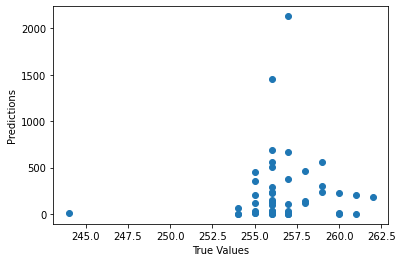

<class 'braindecode.regressor.EEGRegressor'>[initialized](
  module_=Sequential(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1))
    (conv_spat): Conv2d(25, 25, kernel_size=(1, 8), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin): Expression(expression=elu) 
    (pool): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(3, 1), ceil_mode=False)
    (pool_nonlin): Expression(expression=identity) 
    (drop_2): Dropout(p=0.5, inplace=False)
    (conv_2): Conv2d(25, 16, kernel_size=(10, 1), stride=(1, 1), dilation=(3, 1), bias=False)
    (bnorm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin_2): Expression(expression=elu) 
    (pool_2): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(9, 1), ceil_mode=False)
    

In [10]:

predictions = regressor.predict(valid_set)
plt.scatter(valid_set.description[Y],predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
print(".")
plt.show()
print(regressor)
print(regressor.score(valid_set, valid_set.description[Y]))

In [21]:
import numpy as np
import pandas as pd
import torch
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGRegressor
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.datasets import BaseDataset, BaseConcatDataset
from braindecode.training.losses import CroppedLoss
from braindecode.models import Deep4Net
from braindecode.models import ShallowFBCSPNet
from braindecode.models.util import to_dense_prediction_model, get_output_shape
from braindecode.util import set_random_seeds, create_mne_dummy_raw

model_name = "shallow"  # 'shallow' or 'deep'
n_epochs = 3
seed = 20200220

input_window_samples = 6000
batch_size = 64
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

n_chans = 21
# set to how many targets you want to regress (age -> 1, [x, y, z] -> 3)
n_classes = 11

set_random_seeds(seed=seed, cuda=cuda)

# initialize a model, transform to dense and move to gpu
if model_name == "shallow":
    model = ShallowFBCSPNet(
        in_chans=n_chans,
        n_classes=n_classes,
        input_window_samples=input_window_samples,
        n_filters_time=40,
        n_filters_spat=40,
        final_conv_length=35,
    )
    optimizer_lr = 0.000625
    optimizer_weight_decay = 0
elif model_name == "deep":
    model = Deep4Net(
        in_chans=n_chans,
        n_classes=n_classes,
        input_window_samples=input_window_samples,
        n_filters_time=25,
        n_filters_spat=25,
        stride_before_pool=True,
        n_filters_2=int(n_chans * 2),
        n_filters_3=int(n_chans * (2 ** 2.0)),
        n_filters_4=int(n_chans * (2 ** 3.0)),
        final_conv_length=1,
    )
    optimizer_lr = 0.01
    optimizer_weight_decay = 0.0005
else:
    raise ValueError(f'{model_name} unknown')

new_model = torch.nn.Sequential()
for name, module_ in model.named_children():
    if "softmax" in name:
        continue
    new_model.add_module(name, module_)
model = new_model

if cuda:
    model.cuda()

to_dense_prediction_model(model)
n_preds_per_input = get_output_shape(model, n_chans, input_window_samples)[2]


def fake_regression_dataset(n_fake_recs, n_fake_chs, fake_sfreq, fake_duration_s):
    datasets = []
    for i in range(n_fake_recs):
        train_or_eval = "eval" if i == 0 else "train"
        raw, save_fname = create_mne_dummy_raw(
            n_channels=n_fake_chs, n_times=fake_duration_s * fake_sfreq,
            sfreq=fake_sfreq, savedir=None)
        target = np.random.randint(0, 100, n_classes)
        print(target)
        if n_classes == 1:
            target = target[0]
        fake_descrition = pd.Series(
            data=[target, train_or_eval],
            index=["target", "session"])
        base_ds = BaseDataset(raw, fake_descrition, target_name="target")
        datasets.append(base_ds)
    dataset = BaseConcatDataset(datasets)
    return dataset


dataset = fake_regression_dataset(
    n_fake_recs=5, n_fake_chs=21, fake_sfreq=100, fake_duration_s=60)

windows_dataset = create_fixed_length_windows(
    dataset,
    start_offset_samples=0,
    stop_offset_samples=0,
    window_size_samples=input_window_samples,
    window_stride_samples=n_preds_per_input,
    drop_last_window=False,
    drop_bad_windows=True,
)

splits = windows_dataset.split("session")
train_set = splits["train"]
valid_set = splits["eval"]

regressor = EEGRegressor(
    model,
    cropped=True,
    criterion=CroppedLoss,
    criterion__loss_function=torch.nn.functional.mse_loss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),
    optimizer__lr=optimizer_lr,
    optimizer__weight_decay=optimizer_weight_decay,
    iterator_train__shuffle=True,
    batch_size=batch_size,
    callbacks=[
        "neg_root_mean_squared_error",
        # seems n_epochs -1 leads to desired behavior of lr=0 after end of training?
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)

regressor.fit(train_set, y=train_set.description["target"][0], epochs=n_epochs)

Creating RawArray with float64 data, n_channels=21, n_times=6000
    Range : 0 ... 5999 =      0.000 ...    59.990 secs
Ready.
[13 82 99 27 59  3 88 40 32 77 99]
Creating RawArray with float64 data, n_channels=21, n_times=6000
    Range : 0 ... 5999 =      0.000 ...    59.990 secs
Ready.
[52 45 52 12 72 54 63 75 60 97 71]
Creating RawArray with float64 data, n_channels=21, n_times=6000
    Range : 0 ... 5999 =      0.000 ...    59.990 secs
Ready.
[50 92 61  6 56 97 89 46 75 84 62]
Creating RawArray with float64 data, n_channels=21, n_times=6000
    Range : 0 ... 5999 =      0.000 ...    59.990 secs
Ready.
[13  3 24 36 60 12 60 39 99 47 87]
Creating RawArray with float64 data, n_channels=21, n_times=6000
    Range : 0 ... 5999 =      0.000 ...    59.990 secs
Ready.
[40 94  9 64 24 45 92 10 80 33 25]
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1 events and 60

/content/notebooks/braindecode/preprocessing/windowers.py:597: UserWarning: Meaning of `trial_stop_offset_samples`=0 has changed, use `None` to indicate end of trial/recording. Using `None`.
  'Meaning of `trial_stop_offset_samples`=0 has changed, use `None` '


Loading data for 1 events and 6000 original time points ...
Loading data for 1 events and 6000 original time points ...
Loading data for 1 events and 6000 original time points ...
Loading data for 1 events and 6000 original time points ...
Loading data for 1 events and 6000 original time points ...
  epoch    train_loss    train_neg_root_mean_squared_error    valid_loss    valid_neg_root_mean_squared_error     dur
-------  ------------  -----------------------------------  ------------  -----------------------------------  ------
      1     3671.8757                             -58.3547     4113.4941                             -55.7479  0.6687
Loading data for 1 events and 6000 original time points ...
Loading data for 1 events and 6000 original time points ...
Loading data for 1 events and 6000 original time points ...
Loading data for 1 events and 6000 original time points ...
Loading data for 1 events and 6000 original time points ...
Loading data for 1 events and 6000 original ti